### PROPHET OVERALL MODELLING ::

DEBUG:cmdstanpy:input tempfile: /tmp/tmp45t5w6in/5qbv_i2i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp45t5w6in/lqncbj2c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40872', 'data', 'file=/tmp/tmp45t5w6in/5qbv_i2i.json', 'init=/tmp/tmp45t5w6in/lqncbj2c.json', 'output', 'file=/tmp/tmp45t5w6in/prophet_modelw9xmzfxp/prophet_model-20250324020530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:05:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:05:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



MAPE Results by Test Period (in %):
                                Period   MAPE (%)  Count
0  Period 1 (2011-06-08 to 2011-08-05)  12.568077   2387
1  Period 2 (2011-08-05 to 2011-09-29)  14.861097   2387
2  Period 3 (2011-09-29 to 2011-11-09)  25.136154   2387
3  Period 4 (2011-11-09 to 2011-12-09)  18.051036   2389

Overall Test MAPE: 17.65%
Forecast plot saved as 'prophet_forecast_final.png'
Forecast error boxplot saved as 'forecast_error_boxplots_final.png'
Component plots saved as 'prophet_components_final.png'

 Analysis complete. All results and visuals have been saved.


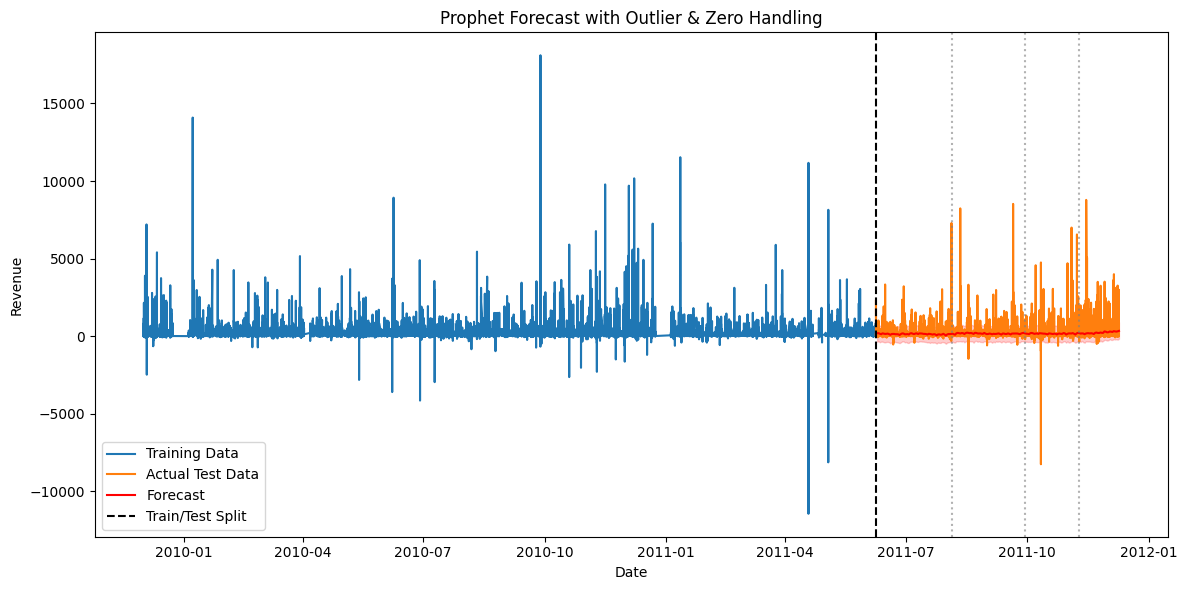

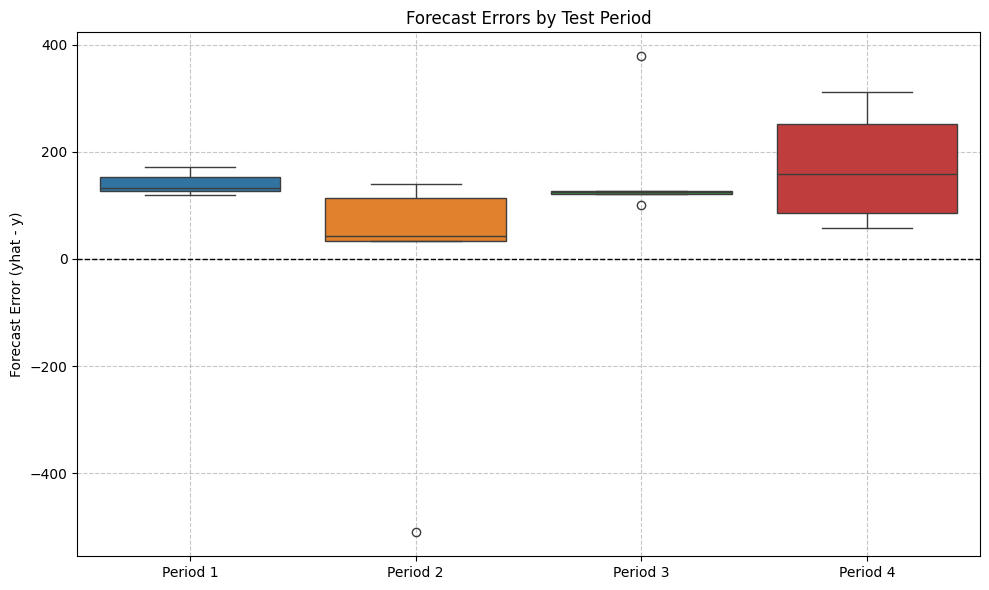

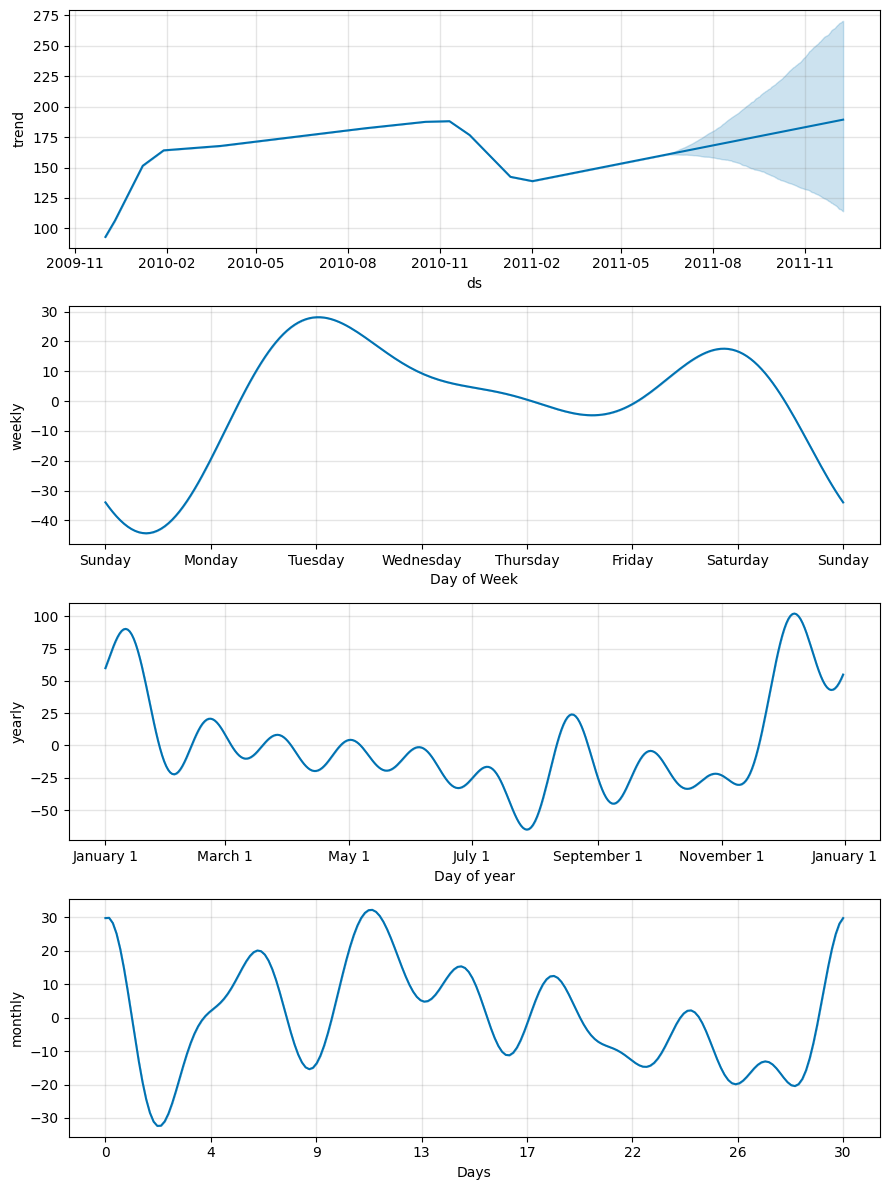

In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('FINAL_DATA.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Revenue'] = df['Quantity'] * df['Price']

daily_data = df.groupby('InvoiceDate')['Revenue'].sum().reset_index()
daily_data = daily_data.rename(columns={'InvoiceDate': 'ds', 'Revenue': 'y'})
daily_data = daily_data.sort_values('ds')
daily_data = daily_data.dropna(subset=['y'])

if len(daily_data) == 0:
    raise ValueError("Dataset is empty after preprocessing. Please check your data.")

# Train/test split
test_percentage = 0.25
test_days = int((daily_data['ds'].max() - daily_data['ds'].min()).days * test_percentage)
cutoff_date = daily_data['ds'].max() - pd.Timedelta(days=test_days)

train_data = daily_data[daily_data['ds'] < cutoff_date].copy()
test_data = daily_data[daily_data['ds'] >= cutoff_date].copy()

# Divide test data into 4 periods
test_period_length = len(test_data) // 4
test_periods = [test_data.iloc[i * test_period_length:(i + 1) * test_period_length if i < 3 else len(test_data)] for i in range(4)]

# Build and train Prophet model
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive'
)
m.add_seasonality(name='monthly', period=30.5, fourier_order=10)
m.fit(train_data)

# Forecast
future = m.make_future_dataframe(periods=test_days)
forecast = m.predict(future)
predictions = forecast[forecast['ds'] >= cutoff_date].copy()

# Evaluate model: Period-wise MAPE
results = []
all_errors = []

for i, period in enumerate(test_periods):
    period_results = period.merge(predictions[['ds', 'yhat']], on='ds', how='left')

    safe_y = period_results['y'].replace(0, 1e-10)
    period_results['ape'] = 100 * np.abs((period_results['y'] - period_results['yhat']) / safe_y)
    period_results['ape'] = period_results['ape'].replace([np.inf, -np.inf], np.nan).fillna(0)
    period_results['ape'] = period_results['ape'].clip(upper=100)

    period_mape = period_results['ape'].mean() * 100
    results.append({
        'Period': f'Period {i+1} ({period["ds"].min().strftime("%Y-%m-%d")} to {period["ds"].max().strftime("%Y-%m-%d")})',
        'MAPE (%)': period_mape,
        #'Median APE (%)': np.median(period_results['ape']),
        'Count': len(period_results)
    })

# Overall MAPE
test_predictions = test_data.merge(predictions[['ds', 'yhat']], on='ds', how='left')
safe_y = test_predictions['y'].replace(0, 1e-10)
test_predictions['ape'] = 100 * np.abs((test_predictions['y'] - test_predictions['yhat']) / safe_y)
test_predictions['ape'] = test_predictions['ape'].replace([np.inf, -np.inf], np.nan).fillna(0)
test_predictions['ape'] = test_predictions['ape'].clip(upper=100)
overall_mape = test_predictions['ape'].mean() * 100

# Display MAPE results
results_df = pd.DataFrame(results)
print("\nMAPE Results by Test Period (in %):")
print(results_df)
print(f"\nOverall Test MAPE: {overall_mape:.2f}%")

# Plot: Forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data['ds'], train_data['y'], label='Training Data')
plt.plot(test_data['ds'], test_data['y'], label='Actual Test Data')
plt.plot(predictions['ds'], predictions['yhat'], label='Forecast', color='red')
plt.fill_between(predictions['ds'], predictions['yhat_lower'], predictions['yhat_upper'], color='red', alpha=0.2)
plt.axvline(x=cutoff_date, color='black', linestyle='--', label='Train/Test Split')

for i in range(1, len(test_periods)):
    plt.axvline(x=test_periods[i]['ds'].iloc[0], color='gray', linestyle=':', alpha=0.6)

plt.title('Prophet Forecast with Outlier & Zero Handling')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.tight_layout()
plt.savefig('prophet_forecast_final.png')
print("Forecast plot saved as 'prophet_forecast_final.png'")

# Compute forecast errors (yhat - y) for each test period
all_forecast_errors = []

for period in test_periods:
    period_results = period.merge(predictions[['ds', 'yhat']], on='ds', how='left')
    period_results['error'] = period_results['yhat'] - period_results['y']
    all_forecast_errors.append(period_results['error'].values)

# Plot: Forecast Error Boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(data=all_forecast_errors)
plt.xticks(range(len(test_periods)), [f'Period {i+1}' for i in range(len(test_periods))])
plt.ylabel('Forecast Error (yhat - y)')
plt.title('Forecast Errors by Test Period')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Optional line at 0 error
plt.tight_layout()
plt.savefig('forecast_error_boxplots_final.png')
print("Forecast error boxplot saved as 'forecast_error_boxplots_final.png'")

# Plot: Component Plots
fig = m.plot_components(forecast)
plt.tight_layout()
plt.savefig('prophet_components_final.png')
print("Component plots saved as 'prophet_components_final.png'")

print("\n Analysis complete. All results and visuals have been saved.")
